In [108]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json

import anndata 
import scanpy as sp
from tqdm import tqdm

In [111]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")

use_CV = True

chromosome = 'chrY'


In [3]:

data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=chromosome)

features = pd.read_hdf(
    fdir_processed / f'feature_importance.{model_type}.sex.h5',
    key=f'{chromosome}',
)

features = features[feature_importance_method]
features = features.sort_values(ascending=False)

data_heart = pd.read_hdf(fdir_external / 'HEART' / 'reg' / "heart.merged.TPM.processed.h5", index_col=0)
data_heart_header = pd.read_csv(fdir_external / 'HEART' / 'reg' / 'SraRunTable.txt', sep=',')
data_heart_header.set_index("Run", inplace=True)

data

,MSTRG.239.15,MSTRG.249.12,MSTRG.250.13,ENST00000432521.2,MSTRG.259.5,ENST00000435221.6,MSTRG.259.7,MSTRG.259.9,ENST00000378567.8,MSTRG.237.18,...,ENST00000363945.1,MSTRG.32721.13,ENST00000358022.6,MSTRG.36725.12,MSTRG.36809.22,ENST00000566193.1,ENST00000361365.7,ENST00000464196.5,ENST00000485584.1,MSTRG.36838.1
ERR188021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.717116,0.421942,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERR188022,0.000000,0.000000,0.799756,1.642583,1.559544,1.346990,1.463835,0.468743,0.000000,0.000000,...,0.373931,0.000000,0.320373,1.966892,1.470729,2.128615,5.973942,2.067816,1.347314,0.349782
ERR188023,1.041698,0.172106,0.181875,0.341884,0.690392,0.000000,0.000000,0.000000,2.055131,0.000000,...,0.794413,0.305703,0.153957,0.000000,0.013347,0.000000,0.000000,0.061599,0.000000,0.000000
ERR188024,1.718304,2.636580,0.000000,2.412521,2.015744,2.011945,1.641659,2.708559,1.183267,0.000000,...,1.484448,0.811534,0.737685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ERR188025,0.092789,0.325591,0.000000,0.198449,0.000000,0.310230,1.547892,1.979350,0.000000,1.278243,...,0.543106,0.000000,0.233628,0.000000,0.006544,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,0.000000,0.000000,2.407727,0.000000,0.000000,0.000000,0.000000,0.000000,1.551798,0.000000,...,0.000000,0.357103,2.424006,0.543860,0.215947,0.000000,0.000000,0.000000,0.000000,0.120564
ERR205020,0.000000,0.000000,0.789096,0.000000,0.000000,1.115314,2.104318,1.862446,0.000000,0.743505,...,0.000000,0.000000,1.163828,1.423022,1.856910,1.307285,5.558860,0.951057,0.219568,0.311004
ERR205021,0.000000,2.766302,0.238701,0.000000,2.002541,2.427571,4.303934,1.500727,3.062893,0.757271,...,0.000000,0.000000,0.000000,0.159181,0.588792,0.585084,4.475096,0.438786,0.155346,0.259788
ERR205022,0.000000,2.351532,1.025341,1.407937,0.000000,0.000000,0.000000,0.000000,2.688904,0.000000,...,0.000000,0.324686,0.319735,0.000000,0.026018,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'UMAP all dataset')

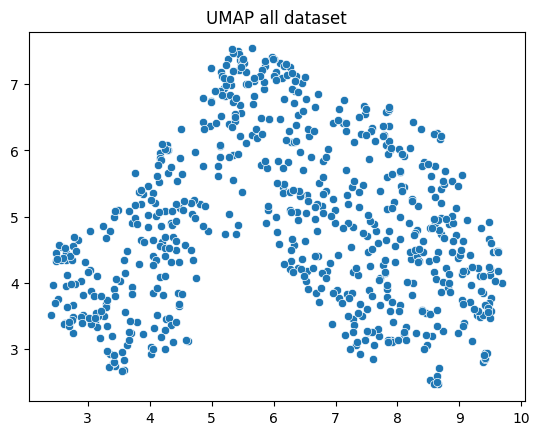

In [18]:
data_geuvadis =  pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key = 'geuvadis')

reducer = umap.UMAP()
embedding = reducer.fit_transform(data_geuvadis)

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
)
plt.title(f'UMAP all dataset')


In [19]:
data_gtf = pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key = 'gtf')
data_gtf = data_gtf.loc[data_gtf['seqname'] == chromosome]

data_header = pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key='header')

data_geuvadis =  pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key = 'geuvadis')
data_geuvadis = data_geuvadis[data_gtf.index]


adata = anndata.AnnData(X=data_geuvadis, 
                        var=data_gtf.loc[data_geuvadis.columns], 
                        obs=data_header.loc[data_geuvadis.index]) 

data_geuvadis['sex'] =  data_header.loc[data_geuvadis.index, 'Sex']
data_geuvadis

,MSTRG.36690.8,MSTRG.36691.6,MSTRG.36702.6,ENST00000711210.1,MSTRG.36705.7,MSTRG.36705.21,ENST00000711197.1,MSTRG.36701.2,ENST00000711235.1,ENST00000711237.1,...,MSTRG.36833.1,ENST00000711264.1,MSTRG.36725.12,MSTRG.36809.22,ENST00000566193.1,ENST00000361365.7,ENST00000464196.5,ENST00000485584.1,MSTRG.36838.1,sex
ERR188021,0.298357,0.186729,0.003915,0.000000,0.000000,0.849876,0.201128,0.003828,1.216267,0.098222,...,0.046646,0.317747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,F
ERR188022,0.391138,0.248443,0.034692,0.000000,1.400249,0.791706,0.000000,0.141921,1.650085,0.094308,...,3.014036,0.335822,1.966892,1.470729,2.128615,5.973942,2.067816,1.347314,0.349782,M
ERR188023,0.386376,0.887412,1.850737,0.645902,0.058217,0.000000,4.939532,0.234429,1.505354,0.047298,...,0.055479,0.136519,0.000000,0.013347,0.000000,0.000000,0.061599,0.000000,0.000000,F
ERR188024,0.482428,1.482096,0.000000,0.000000,0.213939,0.000000,0.000000,0.188400,1.248135,0.225820,...,0.000000,0.293758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,F
ERR188025,0.000000,0.320804,0.880653,0.583724,0.378604,0.000000,4.414067,0.029714,1.042062,0.047497,...,0.000000,0.000000,0.000000,0.006544,0.000000,0.000000,0.000000,0.000000,0.000000,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,2.967808,0.892686,2.390805,1.949501,1.710294,0.000000,0.000000,0.949932,0.000000,2.268825,...,0.000000,0.000000,0.543860,0.215947,0.000000,0.000000,0.000000,0.000000,0.120564,F
ERR205020,0.000000,0.305973,0.098541,0.697163,0.231066,0.237954,0.000000,0.605161,1.114109,0.000000,...,0.531079,0.000000,1.423022,1.856910,1.307285,5.558860,0.951057,0.219568,0.311004,M
ERR205021,0.124237,0.617045,0.056083,0.000000,0.683929,0.409254,0.289369,0.357930,1.836630,0.118623,...,0.000000,0.000000,0.159181,0.588792,0.585084,4.475096,0.438786,0.155346,0.259788,M
ERR205022,0.514327,0.405389,0.046652,0.000000,0.000000,1.489940,0.267724,0.510294,0.000000,2.107804,...,0.000000,0.000000,0.000000,0.026018,0.000000,0.000000,0.000000,0.000000,0.000000,F


(667, 37)

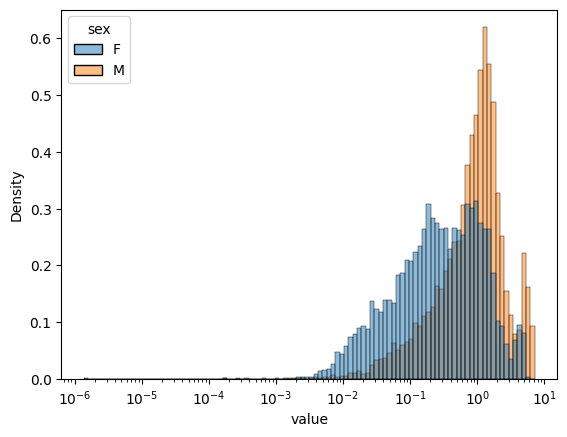

In [20]:
sns.histplot(data_geuvadis.melt('sex'), x='value', hue='sex', log_scale=True,
             stat='density')
data_geuvadis.shape

Text(0.5, 1.0, 'UMAP for chrY')

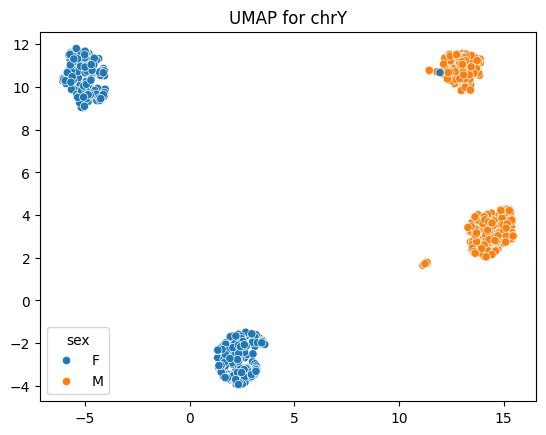

In [21]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_geuvadis.drop(columns=["sex"]))

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=data_geuvadis['sex']
)
plt.title(f'UMAP for {chromosome}')

In [22]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_geuvadis.drop(columns=["sex"]))


Text(0.5, 1.0, 'UMAP for chrY')

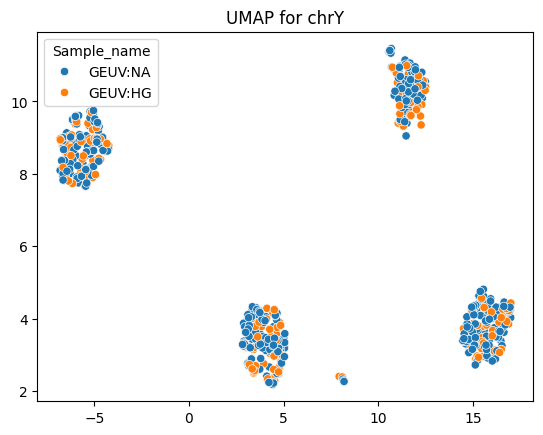

In [23]:

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=adata.obs['Sample_name'].str[:-5]
)
plt.title(f'UMAP for {chromosome}')


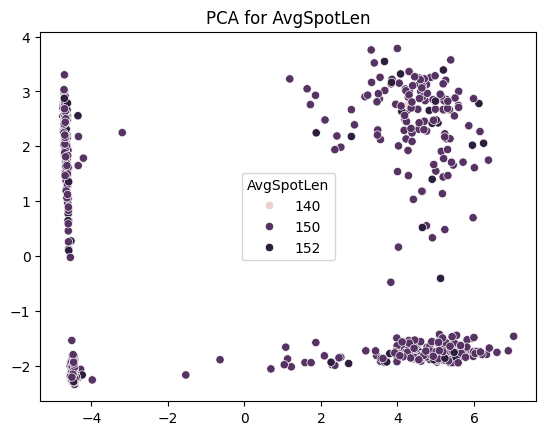

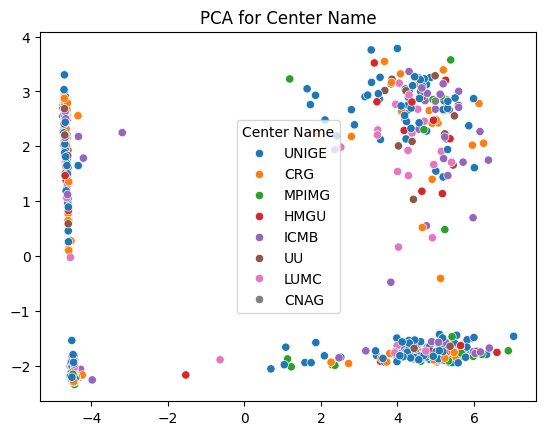

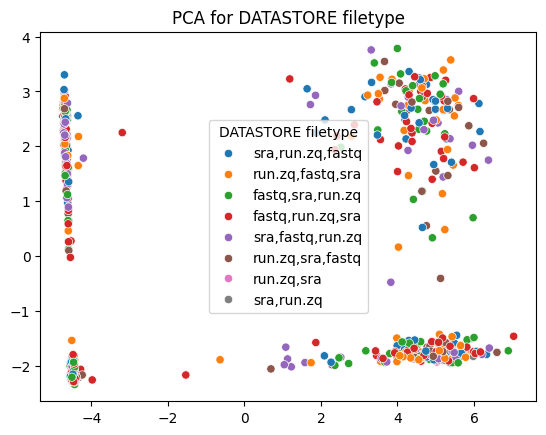

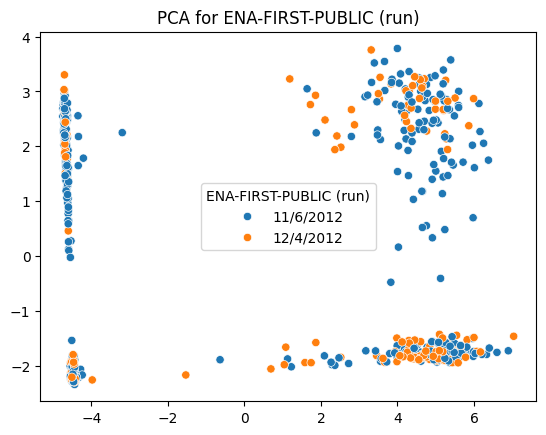

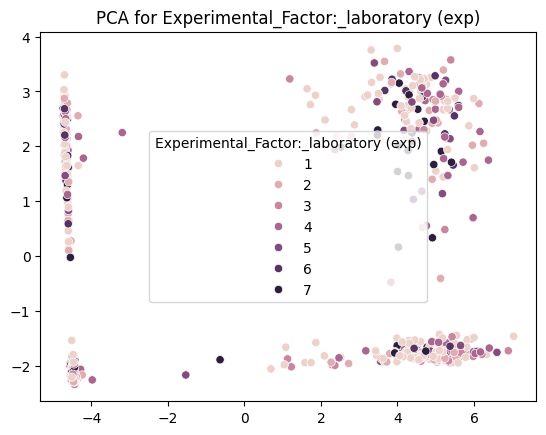

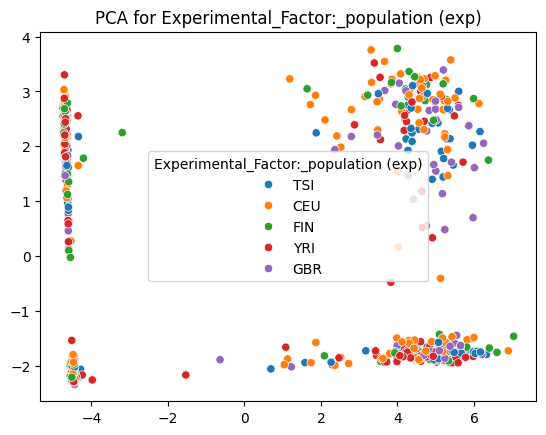

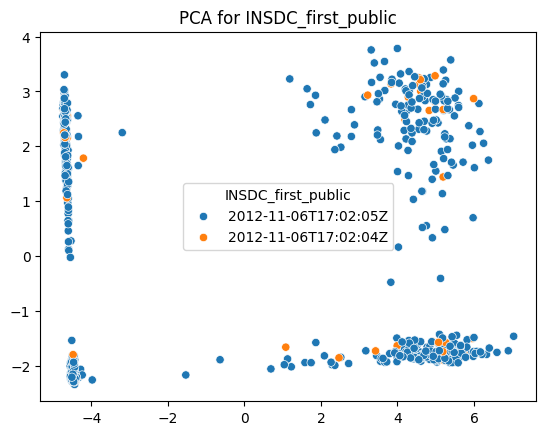

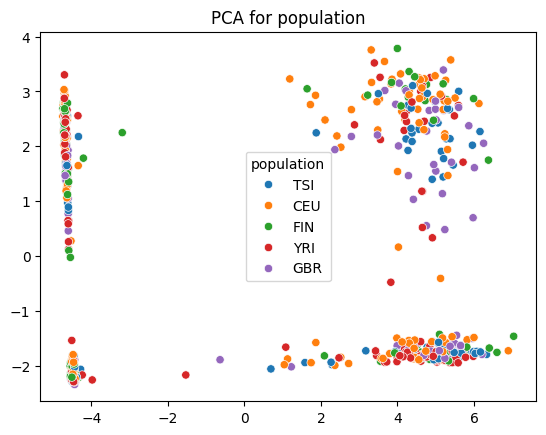

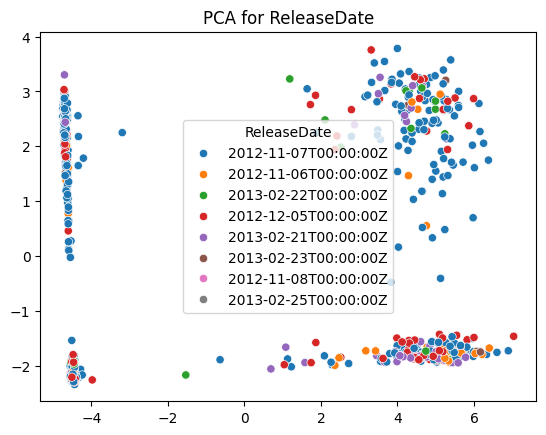

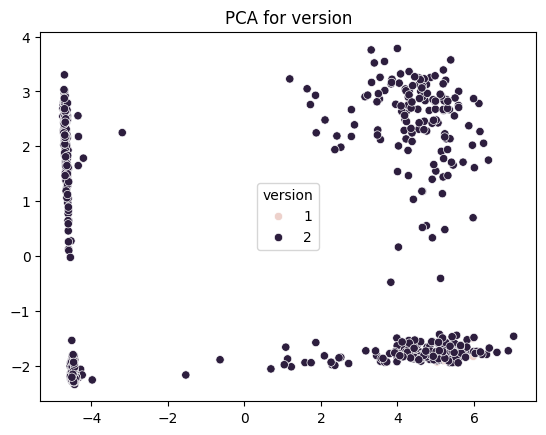

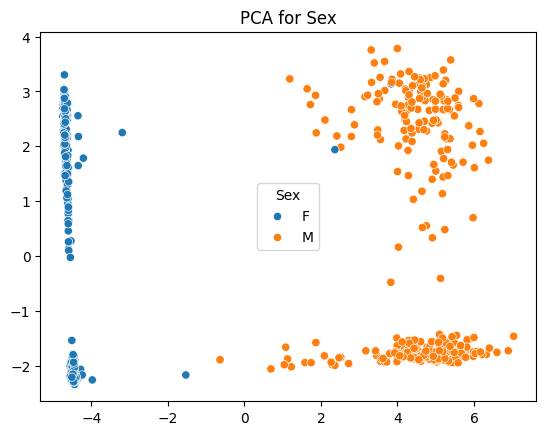

In [25]:
pca = PCA(2).fit(data_geuvadis.drop(columns=["sex"]))

pca_embedding = pca.transform(data_geuvadis.drop(columns=["sex"]))

columns = [
    "AvgSpotLen",
    "Center Name",
    "DATASTORE filetype",
    "ENA-FIRST-PUBLIC (run)",
    "Experimental_Factor:_laboratory (exp)",
    "Experimental_Factor:_population (exp)",
    "INSDC_first_public",
    "population",
    "ReleaseDate",
    "version",
    "Sex",
]

for c in columns:
    sns.scatterplot(
        x=pca_embedding[:, 0],
        y=pca_embedding[:, 1],
        hue=adata.obs[c]
    )
    plt.title(f'PCA for {c}')
    plt.show()

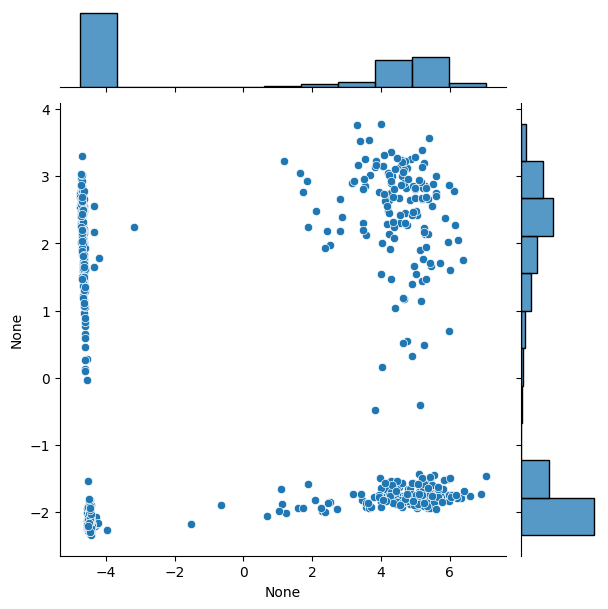

In [100]:
# (data_geuvadis.drop(columns=["sex"]))
# adata.obs.iloc[pca.components_[1].argsort()[::-1][:2]]

# adata.var.iloc[pca.components_[1].argsort()[::-1][0]]

# plt.hist(adata.X[:, pca.components_[1].argsort()[::-1][0]])



sns.jointplot(
    x=pca_embedding[:, 0],
    y=pca_embedding[:, 1],
    # hue=pca_embedding[:, 1] < -1

)
# plt.title(f'PCA for {c}')
plt.show()


<Axes: ylabel='Density'>

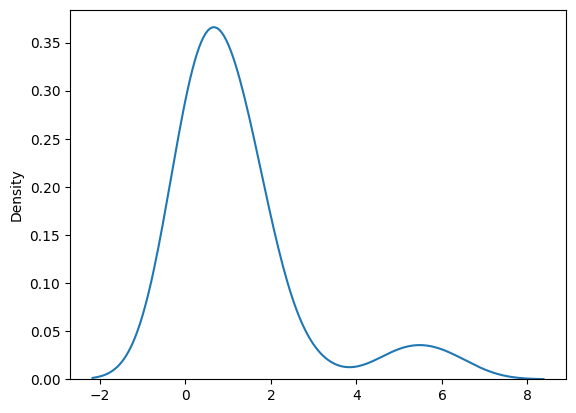

In [106]:
sns.kdeplot(adata.X[pca_embedding[:, 1].argmax()])
# sns.kdeplot(pca_embedding[:, 1])

In [78]:
adata.obs.iloc[pca_embedding[:, 1] < -1]

,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Broker_name,Bytes,Center Name,common_name,Consent,...,ReleaseDate,create_date,version,Sample Name,Sample_name,SRA Study,strain,Submitter_Id,Sample,Sex
ERR188021,RNA-Seq,150,4876174200,PRJEB3366,SAMEA1573446,ArrayExpress,3559612733,UNIGE,human,public,...,2012-11-07T00:00:00Z,2021-10-17T23:14:00Z,2,SAMEA1573446,GEUV:NA20508,ERP001942,lymphoblastoid cell line,GEUV:NA20508,ERR188021,F
ERR188022,RNA-Seq,150,3348579900,PRJEB3366,SAMEA1573207,ArrayExpress,2387687573,UNIGE,human,public,...,2012-11-07T00:00:00Z,2022-07-21T01:31:00Z,2,SAMEA1573207,GEUV:NA12812,ERP001942,lymphoblastoid cell line,GEUV:NA12812,ERR188022,M
ERR188024,RNA-Seq,150,3572181450,PRJEB3366,SAMEA1573203,ArrayExpress,2494830964,UNIGE,human,public,...,2012-11-07T00:00:00Z,2021-10-17T22:59:00Z,2,SAMEA1573203,GEUV:NA12749,ERP001942,lymphoblastoid cell line,GEUV:NA12749,ERR188024,F
ERR188026,RNA-Seq,150,2370019050,PRJEB3366,SAMEA1573212,ArrayExpress,1598862342,MPIMG,human,public,...,2012-11-07T00:00:00Z,2022-07-21T03:21:00Z,2,SAMEA1573212,GEUV:NA20510,ERP001942,lymphoblastoid cell line,GEUV:NA20510,ERR188026,M
ERR188104,RNA-Seq,150,5125167600,PRJEB3366,SAMEA1573115,ArrayExpress,3399351978,HMGU,human,public,...,2012-11-07T00:00:00Z,2021-10-17T23:08:00Z,2,SAMEA1573115,GEUV:NA19146,ERP001942,lymphoblastoid cell line,GEUV:NA19146,ERR188104,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204939,RNA-Seq,150,2744476500,PRJEB3366,SAMEA1573458,ArrayExpress,1803868886,UNIGE,human,public,...,2012-12-05T00:00:00Z,2022-07-14T06:17:00Z,2,SAMEA1573458,GEUV:NA12155,ERP001942,lymphoblastoid cell line,GEUV:NA12155,ERR204939,M
ERR204940,RNA-Seq,150,3796179000,PRJEB3366,SAMEA1573176,ArrayExpress,2548891274,ICMB,human,public,...,2012-12-05T00:00:00Z,2021-10-19T03:08:00Z,2,SAMEA1573176,GEUV:NA18861,ERP001942,lymphoblastoid cell line,GEUV:NA18861,ERR204940,F
ERR205020,RNA-Seq,150,2607598050,PRJEB3366,SAMEA1573157,ArrayExpress,1713213648,UNIGE,human,public,...,2013-02-21T00:00:00Z,2022-07-22T21:01:00Z,2,SAMEA1573157,GEUV:NA19198,ERP001942,lymphoblastoid cell line,GEUV:NA19198,ERR205020,M
ERR205021,RNA-Seq,150,2623394250,PRJEB3366,SAMEA1573421,ArrayExpress,1765067265,UNIGE,human,public,...,2013-02-21T00:00:00Z,2022-07-16T21:05:00Z,2,SAMEA1573421,GEUV:NA19210,ERP001942,lymphoblastoid cell line,GEUV:NA19210,ERR205021,M


In [79]:

adata.obs.iloc[pca_embedding[:, 1] > -1]

,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Broker_name,Bytes,Center Name,common_name,Consent,...,ReleaseDate,create_date,version,Sample Name,Sample_name,SRA Study,strain,Submitter_Id,Sample,Sex
ERR188023,RNA-Seq,152,5548298680,PRJEB3366,SAMEA1573500,ArrayExpress,3922060114,CRG,human,public,...,2012-11-07T00:00:00Z,2021-10-17T23:19:00Z,2,SAMEA1573500,GEUV:HG00315,ERP001942,lymphoblastoid cell line,GEUV:HG00315,ERR188023,F
ERR188025,RNA-Seq,152,5348693800,PRJEB3366,SAMEA1573346,ArrayExpress,3609467912,CRG,human,public,...,2012-11-07T00:00:00Z,2022-07-22T21:12:00Z,2,SAMEA1573346,GEUV:HG00377,ERP001942,lymphoblastoid cell line,GEUV:HG00377,ERR188025,F
ERR188105,RNA-Seq,150,4502934900,PRJEB3366,SAMEA1573315,ArrayExpress,3012777837,HMGU,human,public,...,2012-11-06T00:00:00Z,2022-07-13T19:36:00Z,2,SAMEA1573315,GEUV:NA20768,ERP001942,lymphoblastoid cell line,GEUV:NA20768,ERR188105,F
ERR188106,RNA-Seq,150,3895449000,PRJEB3366,SAMEA1573267,ArrayExpress,2650277839,MPIMG,human,public,...,2012-11-06T00:00:00Z,2022-07-12T21:57:00Z,2,SAMEA1573267,GEUV:HG00247,ERP001942,lymphoblastoid cell line,GEUV:HG00247,ERR188106,F
ERR188189,RNA-Seq,152,4110066016,PRJEB3366,SAMEA1573286,ArrayExpress,2921704227,CRG,human,public,...,2012-11-07T00:00:00Z,2022-07-22T21:04:00Z,2,SAMEA1573286,GEUV:HG00133,ERP001942,lymphoblastoid cell line,GEUV:HG00133,ERR188189,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR188436,RNA-Seq,150,3234186900,PRJEB3366,SAMEA1573285,ArrayExpress,2360769558,UNIGE,human,public,...,2012-11-07T00:00:00Z,2022-07-29T18:00:00Z,2,SAMEA1573285,GEUV:NA20540,ERP001942,lymphoblastoid cell line,GEUV:NA20540,ERR188436,F
ERR188437,RNA-Seq,150,8412674100,PRJEB3366,SAMEA1573536,ArrayExpress,5916704235,LUMC,human,public,...,2012-11-07T00:00:00Z,2022-07-22T21:29:00Z,2,SAMEA1573536,GEUV:NA20803,ERP001942,lymphoblastoid cell line,GEUV:NA20803,ERR188437,M
ERR204937,RNA-Seq,150,2938127850,PRJEB3366,SAMEA1573211,ArrayExpress,1951852767,UNIGE,human,public,...,2013-02-21T00:00:00Z,2022-07-17T06:16:00Z,2,SAMEA1573211,GEUV:NA20512,ERP001942,lymphoblastoid cell line,GEUV:NA20512,ERR204937,M
ERR204938,RNA-Seq,150,2232165150,PRJEB3366,SAMEA1573178,ArrayExpress,1493779202,UNIGE,human,public,...,2013-02-21T00:00:00Z,2021-10-19T02:47:00Z,2,SAMEA1573178,GEUV:NA19257,ERP001942,lymphoblastoid cell line,GEUV:NA19257,ERR204938,F


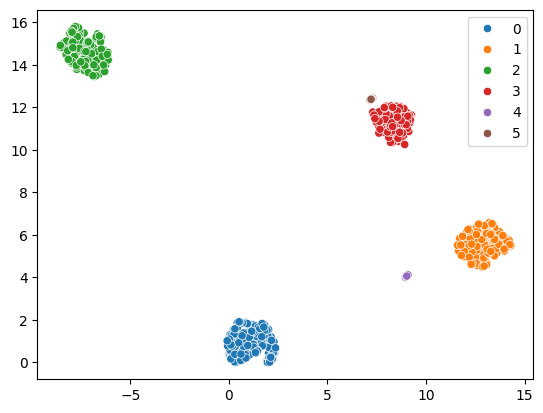

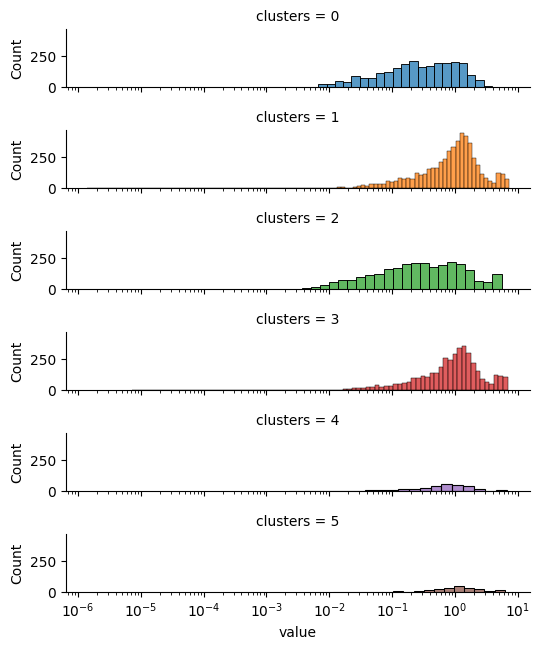

In [195]:
from sklearn.cluster import KMeans, DBSCAN

# kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(embedding)
clusters = DBSCAN().fit(embedding)

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=clusters.labels_,
    palette='tab10'
)
plt.show()

data_geuvadis = data_geuvadis.drop(columns='sex')
data_geuvadis['clusters'] = clusters.labels_

# sns.histplot(data_geuvadis.melt('clusters'), 
#              x='value', 
#              hue='clusters', log_scale=True,
#              stat='density', palette='tab10')
# plt.show()

g = sns.FacetGrid(data_geuvadis.melt('clusters'), 
              row="clusters", 
              hue="clusters", height=1.1, aspect=5,
              palette='tab10')


g.map(sns.histplot, 'value', log_scale=True)
# g.figure.subplots_adjust(hspace=-.15)

# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)

# plt.tight_layout()
# plt.show()

In [209]:
import scanpy
import anndata
import bbknn

# bbknn.bbknn(adata)

In [232]:
# data_geuvadis,  data_header
# data_header

adata = anndata.AnnData(X=data_geuvadis.drop(columns='clusters'), 
                        var=data_gtf.loc[data_geuvadis.drop(columns='clusters').columns], 
                        obs=data_header.loc[data_geuvadis.index]) 

# bbknn.bbknn(adata, batch_key='Sex')
scanpy.tl.pca(adata)
bbknn.bbknn(adata, batch_key='Sex')
scanpy.tl.leiden(adata)
bbknn.ridge_regression(adata, batch_key=['Sex'], confounder_key=['leiden'])
scanpy.tl.pca(adata)

# scanpy.tl.leiden(adata)


Text(0.5, 1.0, 'UMAP for chrY')

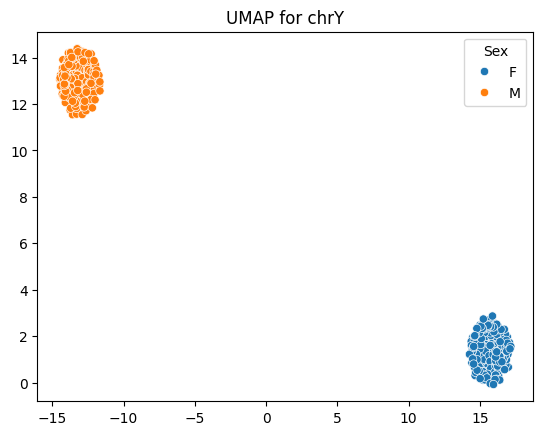

In [241]:


reducer = umap.UMAP()
embedding = reducer.fit_transform(adata.layers['X_explained'])

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=adata.obs['sex']
)
plt.title(f'UMAP for {chromosome}')

<Axes: xlabel='value', ylabel='Count'>

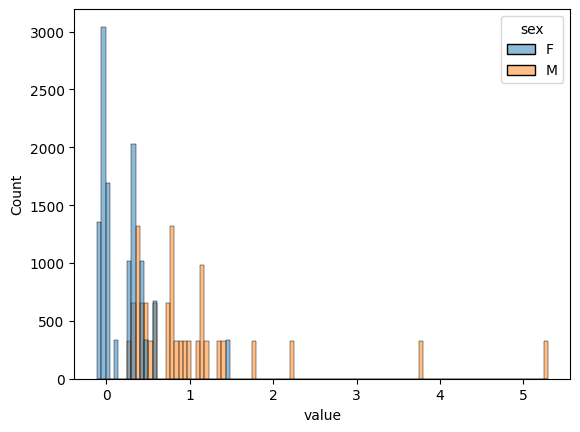

In [256]:
# adata.layers['X_explained']
data_corrected = adata.to_df('X_explained')
data_corrected['sex'] = adata.obs['Sex']
# data_corrected
sns.histplot(data_corrected.melt('sex'), x='value', hue='sex', log_scale=True)



In [264]:
adata.obs.columns

Index(['Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample',
       'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent',
       'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region',
       'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)',
       'ENA_last_update', 'Experiment',
       'Experimental_Factor:_laboratory (exp)',
       'Experimental_Factor:_population (exp)', 'external_id',
       'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public',
       'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name',
       'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism',
       'Platform', 'population', 'ReleaseDate', 'create_date', 'version',
       'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id',
       'Sample', 'Sex', 'leiden', 'n_counts_all'],
      dtype='object')

In [257]:
adata

AnnData object with n_obs × n_vars = 667 × 35
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex', 'leiden', 'n_counts_all'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id', 'n_counts'
    uns:

In [112]:
header = pd.read_hdf(fdir_processed/'geuvadis.preprocessed.h5', key='header')

data = data[features.iloc[:n_features].index]
data['Sex'] = header['Sex']

/tmp/ipykernel_8144/2202968063.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sex'] = header['Sex']


(667, 51)

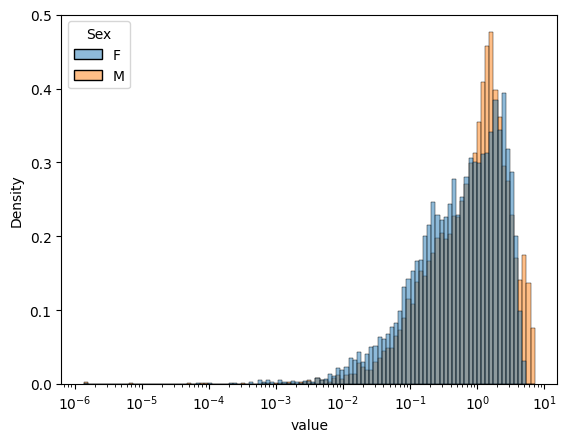

In [25]:
sns.histplot(data.melt('Sex'), x='value', hue='Sex', log_scale=True,
             stat='density')
data.shape

<Axes: xlabel='value', ylabel='Count'>

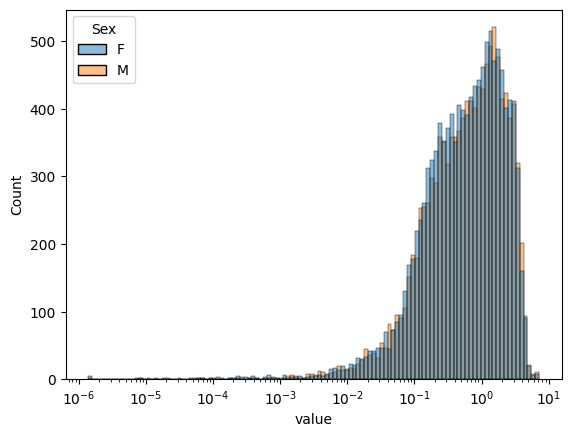

In [26]:
data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=chromosome)
data['Sex'] = header['Sex']

features = features.loc[features.index.intersection(data_heart.columns)]
features = features.sort_values(ascending=False)
features = features.iloc[:n_features]

# features
sns.histplot(data[features.index.union(["Sex"])].melt("Sex"), x='value', hue='Sex', log_scale=True)


In [27]:
features.index

Index(['MSTRG.10535.1', 'ENST00000556551.2', 'MSTRG.10521.2', 'MSTRG.10511.6',
       'ENST00000555567.6', 'MSTRG.10504.12', 'ENST00000476562.5',
       'MSTRG.10504.8', 'MSTRG.10504.4', 'ENST00000577272.1', 'MSTRG.10521.3',
       'MSTRG.10495.5', 'MSTRG.10476.14', 'ENST00000541357.6',
       'MSTRG.10518.13', 'MSTRG.10466.13', 'ENST00000680030.1',
       'ENST00000469797.5', 'MSTRG.10529.2', 'ENST00000554064.5',
       'ENST00000529180.1', 'ENST00000555818.5', 'MSTRG.10540.3',
       'MSTRG.10484.42', 'ENST00000283285.10', 'ENST00000555144.5',
       'ENST00000653562.3', 'MSTRG.5794.10', 'ENST00000469778.1',
       'ENST00000544280.6', 'ENST00000554308.5', 'MSTRG.10735.4',
       'ENST00000298896.7', 'ENST00000303562.9', 'ENST00000684261.1',
       'ENST00000554752.7', 'ENST00000555347.1', 'MSTRG.10548.19',
       'MSTRG.10591.24', 'MSTRG.10591.26', 'MSTRG.10729.5', 'MSTRG.8571.5',
       'ENST00000066544.8', 'MSTRG.10731.1', 'ENST00000556018.5',
       'ENST00000514907.5', 'MSTRG.10

<Axes: xlabel='value', ylabel='Count'>

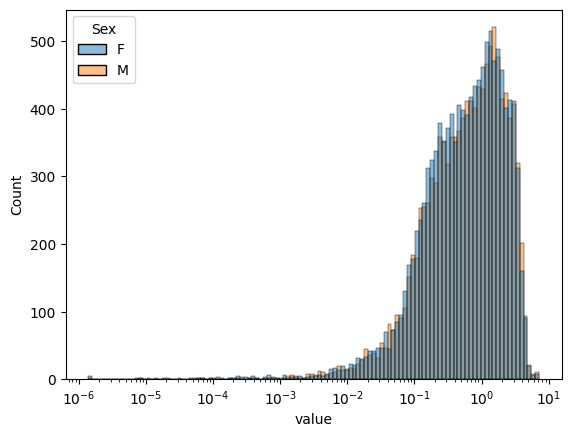

In [28]:

# features
sns.histplot(data[features.index.union(["Sex"])].melt("Sex"), x='value', hue='Sex', log_scale=True)
# features.shape

In [29]:
data_heart['Sex'] = data_heart_header['sex']

(20, 102379)

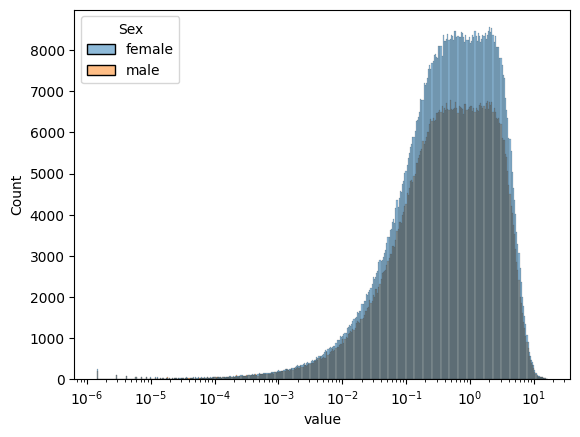

In [30]:
sns.histplot(data_heart.melt('Sex'), x='value', hue='Sex', log_scale=True)
data_heart.shape